# Predicting Forest Cover Type

Aiming to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables. The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were  derived from data obtained from the US Geological Survey and USFS.

The seven types of cover types are:

1 - Spruce/Fir

2 - Lodgepole Pine

3 - Ponderosa Pine

4 - Cottonwood/Willow

5 - Aspen

6 - Douglas-fir

7 - Krummholz



In [1]:
import pandas as pd
import numpy as np
import timeit
from extrafunctions import pipeline_fn as pfn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

np.random.seed(123)

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Getting the data

In [2]:
forest_data = pd.read_csv('C:/Users/willjdsouza/Desktop/Work/Portfolio/covtype.csv') #importing as a dataframe
forest_data.head(5)  #sample of data

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
forest_data.shape #shape of data

(581012, 55)

In [4]:
forest_data.isnull().sum() #checking if they are any null values, also you can see the features in the dataset here

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0


## Exploring the Data

Below are some sample graphs I made with Tableau. I have just shown a few samples (for the sake of the notebook not being absurdly long) of the way I observed the data visually.

One thing to note is that I am only showing one chart for Soil Type vs Cover Type. This is becuase they are actualyl 40 soil types, however, for lack of repition I have chosen to only show from Soil Type 1-10.

In [5]:
forest_data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060,2.051471
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791,1.396504
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000


<img src="WA.BY.CT.png"> 
<img src="ST.BY.CT.png">
<img src="/willjdsouza/Projects/blob/master/CT.BY.E.PNG?raw=true" alt="CT.BY.E.PNG">

From taking a look at these graphs and looking at the describe() table we can see that the cover types are somewhat unique in terms of wilderness area, soil type, and elevation. We can seethat majority of each cover type is somwhat found its own unique area.

This is a great indication that a classification model may work well!

## Preparing the Data

In [6]:
X = forest_data.drop('Cover_Type', axis=1) #features for training
y = forest_data.loc[:, ['Cover_Type']] #target variable

X_train, X_test, y_train, y_test,  = train_test_split(X, y, test_size=0.2, random_state=42) #random split for train and test sets

print("X_train length:", len(X_train))
print("X_test length:", len(X_test))
print("y_train length:", len(y_train))
print("y_test length:", len(y_test))


X_train length: 464809
X_test length: 116203
y_train length: 464809
y_test length: 116203


In [7]:
#Building a full pipeline for data transformation

numerical_values = list(X_train[['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
                     'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                     'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']])

catergorical_values = list(X_train[['Wilderness_Area1','Wilderness_Area2','Wilderness_Area3','Wilderness_Area4','Soil_Type1',
                                    'Soil_Type2', 'Soil_Type3','Soil_Type4','Soil_Type5','Soil_Type6','Soil_Type7','Soil_Type8',
                                    'Soil_Type9','Soil_Type10', 'Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14',
                                    'Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19','Soil_Type20',
                                    'Soil_Type21','Soil_Type22','Soil_Type23','Soil_Type24','Soil_Type25','Soil_Type26',
                                    'Soil_Type27','Soil_Type28','Soil_Type29','Soil_Type30','Soil_Type31','Soil_Type32',
                                    'Soil_Type33','Soil_Type34','Soil_Type35','Soil_Type36','Soil_Type37','Soil_Type38',
                                    'Soil_Type39','Soil_Type40']])

num_pipeline = Pipeline([
        ('selector', pfn.DataFrameSelector(numerical_values)),
        ('std_scaler', StandardScaler()), #scaling data using a standard scaler
    ])

cat_pipeline = Pipeline([
        ('selector', pfn.DataFrameSelector(catergorical_values)), #no need to encode variables, they are binary
    ]) 


full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
])

X_train_prepared = full_pipeline.fit_transform(X_train) 
X_test_prepared = full_pipeline.transform(X_test)

C:\Users\willjdsouza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\willjdsouza\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Short Listing Models

For the models short listed to train with default hyperparameters, I have chosen an SGD Classifier, Naive Bayes Classifier, Random Forest Classifier, and a KNN Classifer. As well, I have used TensorFlow to train a DNN in to determine if this may score better. I have chosen some linear classifiers, however they will be able to pass by a OvA strategy in order for multiclass prediction.

In [8]:
# SGD Classifier
sgd = SGDClassifier()
start_sgd = timeit.default_timer()
sgd.fit(X_train_prepared, np.ravel(y_train))
sgd_predicted = sgd.predict(X_train_prepared)
stop_sgd = timeit.default_timer()
sgd_accuracy = accuracy_score(sgd_predicted, np.ravel(y_train))
sgd_precision = precision_score(sgd_predicted, np.ravel(y_train), average = 'weighted')


#Nave Bayes Classifier
gnb = GaussianNB()
start_gnb = timeit.default_timer()
gnb.fit(X_train_prepared, np.ravel(y_train))
gnb_predicted = gnb.predict(X_train_prepared)
stop_gnb = timeit.default_timer()
gnb_accuracy = accuracy_score(gnb_predicted, np.ravel(y_train))
gnb_precision = precision_score(gnb_predicted, np.ravel(y_train), average = 'weighted')


#Random Forest Classifier
rfc = RandomForestClassifier()
start_rfc = timeit.default_timer()
rfc.fit(X_train_prepared, np.ravel(y_train))
rfc_predicted = rfc.predict(X_train_prepared)
stop_rfc = timeit.default_timer()
rfc_accuracy = accuracy_score(rfc_predicted, np.ravel(y_train))
rfc_precision = precision_score(rfc_predicted, np.ravel(y_train), average = 'weighted')


#Nearest Neighbors Classifier
knn = KNeighborsClassifier()
start_knn = timeit.default_timer()
knn.fit(X_train_prepared, np.ravel(y_train))
knn_predicted = knn.predict(X_train_prepared)
stop_knn = timeit.default_timer()
knn_accuracy = accuracy_score(knn_predicted, np.ravel(y_train))
knn_precision = precision_score(knn_predicted, np.ravel(y_train), average = 'weighted')

print("SGD Accuracy Score:", sgd_accuracy, "SGD Precision Score:", sgd_precision)
print("GNB Accuracy Score:", gnb_accuracy, "GNB Precision Score:", gnb_precision)
print("RFC Accuracy Score:", rfc_accuracy, "RFC Precision Score:", rfc_precision)
print("KNN Accuracy Score:", knn_accuracy, "KNN Precision Score:", knn_precision)

C:\Users\willjdsouza\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGD Accuracy Score: 0.711464278876 SGD Precision Score: 0.753295750292
GNB Accuracy Score: 0.0923583665549 GNB Precision Score: 0.735809940852
RFC Accuracy Score: 0.997945392624 RFC Precision Score: 0.99795239486
KNN Accuracy Score: 0.956244392858 KNN Precision Score: 0.956498156331


With default settings, we can see that Random Forest and KNN perform very well! Without even tuning the Random Forest, we have an almost perfect accuracy and precision score.

##### Neural Networking

In order to train the deep neural network, I have chosen two layers with 50 and 30 in teh 1st and 2nd layer. As well, I have used the Adam Optimizer to help train the network. Althought in recent news, they are some concerns with this optimizer, I found it still worked best.

In [9]:
feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train_prepared)

dnn_classifer = tf.contrib.learn.DNNClassifier(hidden_units= [50,30], feature_columns=feature_cols,
                                            optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
                                            n_classes = 8)
                                        
dnn_classifer = tf.contrib.learn.SKCompat(dnn_classifer)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F7A4DA8F98>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'C:\\Users\\WILLJD~1\\AppData\\Local\\Temp\\tmp49phijk0'}


In [10]:
dnn_classifer.fit(X_train_prepared, np.ravel(y_train), steps = 20001, batch_size= 50) 

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\WILLJD~1\AppData\Local\Temp\tmp49phijk0\model.ckpt.
INFO:tensorflow:loss = 1.89961, step = 1
INFO:tensorflow:global_step/sec: 796.158
INFO:tensorflow:loss = 1.35686, step = 101 (0.126 sec)
INFO:tensorflow:global_step/sec: 896.215
INFO:tensorflow:loss = 0.936467, step = 201 (0.112 sec)
INFO:tensorflow:global_step/sec: 938.315
INFO:tensorflow:loss = 0.804001, step = 301 (0.107 sec)
INFO:tensorflow:global_step/sec: 919.598
INFO:tensorflow:loss = 0.708095, step = 401 (0.109 sec)
INFO:tensorflow:global_step/sec: 876.633
INFO:tensorflow:loss = 0.786937, step = 501 (0.114 

INFO:tensorflow:loss = 0.517917, step = 7601 (0.108 sec)
INFO:tensorflow:global_step/sec: 796.101
INFO:tensorflow:loss = 0.652735, step = 7701 (0.126 sec)
INFO:tensorflow:global_step/sec: 891.466
INFO:tensorflow:loss = 0.383641, step = 7801 (0.112 sec)
INFO:tensorflow:global_step/sec: 829.291
INFO:tensorflow:loss = 0.49116, step = 7901 (0.120 sec)
INFO:tensorflow:global_step/sec: 770.672
INFO:tensorflow:loss = 0.466249, step = 8001 (0.130 sec)
INFO:tensorflow:global_step/sec: 970.199
INFO:tensorflow:loss = 0.55549, step = 8101 (0.103 sec)
INFO:tensorflow:global_step/sec: 900.258
INFO:tensorflow:loss = 0.446637, step = 8201 (0.111 sec)
INFO:tensorflow:global_step/sec: 900.585
INFO:tensorflow:loss = 0.386417, step = 8301 (0.111 sec)
INFO:tensorflow:global_step/sec: 992.902
INFO:tensorflow:loss = 0.505638, step = 8401 (0.101 sec)
INFO:tensorflow:global_step/sec: 912.601
INFO:tensorflow:loss = 0.458949, step = 8501 (0.110 sec)
INFO:tensorflow:global_step/sec: 884.167
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 616.848
INFO:tensorflow:loss = 0.387908, step = 16001 (0.162 sec)
INFO:tensorflow:global_step/sec: 793.088
INFO:tensorflow:loss = 0.820406, step = 16101 (0.126 sec)
INFO:tensorflow:global_step/sec: 443.143
INFO:tensorflow:loss = 0.536869, step = 16201 (0.226 sec)
INFO:tensorflow:global_step/sec: 740.1
INFO:tensorflow:loss = 0.48261, step = 16301 (0.135 sec)
INFO:tensorflow:global_step/sec: 861.467
INFO:tensorflow:loss = 0.611368, step = 16401 (0.116 sec)
INFO:tensorflow:global_step/sec: 585.789
INFO:tensorflow:loss = 0.446405, step = 16501 (0.170 sec)
INFO:tensorflow:global_step/sec: 914.156
INFO:tensorflow:loss = 0.502187, step = 16601 (0.110 sec)
INFO:tensorflow:global_step/sec: 863.176
INFO:tensorflow:loss = 0.537293, step = 16701 (0.116 sec)
INFO:tensorflow:global_step/sec: 632.463
INFO:tensorflow:loss = 0.48946, step = 16801 (0.162 sec)
INFO:tensorflow:global_step/sec: 868.951
INFO:tensorflow:loss = 0.669746, step = 16901 (0.111 sec)
INFO:tensorflo

SKCompat()

Looking at the TensorBoard chart below that is outlining the loss during the training, we can see that we found a minimal point around 14,000 steps. We will now run our model again with 14,200 steps in order to possibly obtain higher scores, although this may not be guaranteed.

<img src="Capture.png">

In [11]:
start_dnn = timeit.default_timer()
dnn_classifer.fit(X_train_prepared, np.ravel(y_train), steps = 14201, batch_size= 50) 
dnn_predicted = dnn_classifer.predict(X_train_prepared)
stop_dnn = timeit.default_timer()
dnn_predictions = dnn_predicted['classes']

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from C:\Users\WILLJD~1\AppData\Local\Temp\tmp49phijk0\model.ckpt-20001
INFO:tensorflow:Saving checkpoints for 20002 into C:\Users\WILLJD~1\AppData\Local\Temp\tmp49phijk0\model.ckpt.
INFO:tensorflow:loss = 0.446463, step = 20002
INFO:tensorflow:global_step/sec: 920.308
INFO:tensorflow:loss = 0.470152, step = 20102 (0.110 sec)
INFO:tensorflow:global_step/sec: 979.57
INFO:tensorflow:loss = 0.455371, step = 20202 (0.103 sec)
INFO:tensorflow:global_step/sec: 834.877
INFO:tensorflow:loss = 0.506634, step = 20302 (0.119 sec)
INFO:tensorflow:global_step/sec: 942.727
INFO:tensorflow:loss = 0.

INFO:tensorflow:loss = 0.489441, step = 27402 (0.191 sec)
INFO:tensorflow:global_step/sec: 796.244
INFO:tensorflow:loss = 0.374534, step = 27502 (0.126 sec)
INFO:tensorflow:global_step/sec: 622.327
INFO:tensorflow:loss = 0.387807, step = 27602 (0.161 sec)
INFO:tensorflow:global_step/sec: 552.043
INFO:tensorflow:loss = 0.527893, step = 27702 (0.181 sec)
INFO:tensorflow:global_step/sec: 679.791
INFO:tensorflow:loss = 0.315891, step = 27802 (0.148 sec)
INFO:tensorflow:global_step/sec: 846.853
INFO:tensorflow:loss = 0.377831, step = 27902 (0.118 sec)
INFO:tensorflow:global_step/sec: 925.182
INFO:tensorflow:loss = 0.414141, step = 28002 (0.108 sec)
INFO:tensorflow:global_step/sec: 858.574
INFO:tensorflow:loss = 0.511438, step = 28102 (0.116 sec)
INFO:tensorflow:global_step/sec: 936.975
INFO:tensorflow:loss = 0.408973, step = 28202 (0.107 sec)
INFO:tensorflow:global_step/sec: 825.858
INFO:tensorflow:loss = 0.322479, step = 28302 (0.122 sec)
INFO:tensorflow:global_step/sec: 696.374
INFO:tenso

In [12]:
dnn_accuracy = accuracy_score(dnn_predictions, np.ravel(y_train))
dnn_precision = precision_score(dnn_predictions, np.ravel(y_train), average="weighted")
print("DNN Accuracy Score:", dnn_accuracy)
print("DNN Precision Score:", dnn_precision)

DNN Accuracy Score: 0.822720730451
DNN Precision Score: 0.834330891551


It does not look like our model performed better than the Random Forest Classifer or even the KNN classifier. Although, it was rocket fast...

## Comparing Models

Below are a few visualization that comapre all the models above comparing:

1) SGD Classifier

2) GNB CLassifier

3) Random Forest Classifier

4) KNN Classifier

5) Deep Neural Network

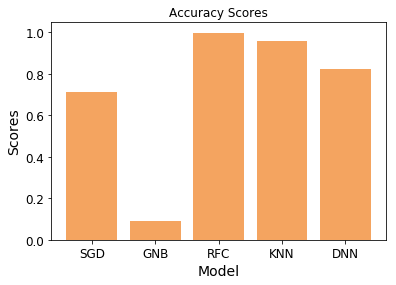

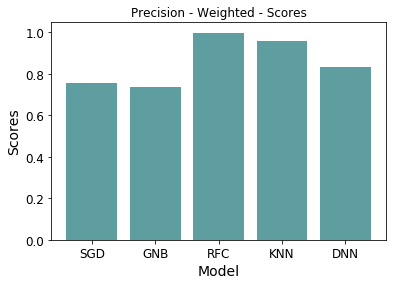

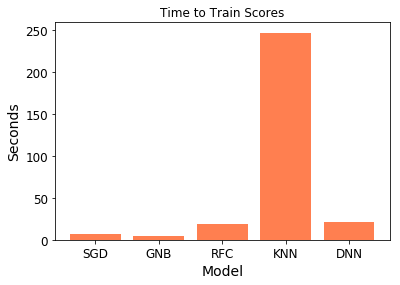

In [13]:
model =['SGD','GNB','RFC','KNN','DNN']
pos = np.arange(len(model))
accuracy_scores = [sgd_accuracy, gnb_accuracy, rfc_accuracy, knn_accuracy, dnn_accuracy]
precision_scores = [sgd_precision, gnb_precision, rfc_precision, knn_precision, dnn_precision]
time_to_run = [stop_sgd - start_sgd, stop_gnb - start_gnb, stop_rfc - start_rfc, stop_knn - start_knn, stop_dnn - start_dnn]


plt.bar(pos,accuracy_scores, color = "sandybrown")
plt.xticks(pos, model)
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Accuracy Scores')
plt.show()

plt.bar(pos,precision_scores, color = "cadetblue")
plt.xticks(pos, model)
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Precision - Weighted - Scores')
plt.show()

plt.bar(pos,time_to_run, color = "coral")
plt.xticks(pos, model)
plt.xlabel('Model')
plt.ylabel('Seconds')
plt.title('Time to Train Scores')
plt.show()

The highest scores obtained was the Random Forest Classifier in all categories except the time taken to train & make prediction. Although the DNN beat it in this category, the Random Forest Classifier will be chosen as the go-to model because of its high scores and minimal run time.

## Test Predicitions with RFC

Although we could spend more time hypertuning the parameters, with such high scores there is almost absolutely no need to. The default model performs exceptionally well on the training set. We can go ahead and skip to now making predicitiosn on our test set.

The predicitions are pretty close to the same error we saw with the trainnig set, the classification model works well!

In [14]:
rfc_test_predicted = rfc.predict(X_test_prepared)
rfc_test_accuracy = accuracy_score(rfc_test_predicted, np.ravel(y_test))
rfc_test_precision = precision_score(rfc_test_predicted, np.ravel(y_test), average = 'weighted')
rfc_test_recall = recall_score(rfc_test_predicted, np.ravel(y_test), average = 'weighted')
rfc_test_f1 = f1_score(rfc_test_predicted, np.ravel(y_test), average = 'weighted')

print("RFC Accuracy Test Score:", rfc_test_accuracy)
print("RFC Precision Test Score:", rfc_test_precision)
print("RFC Recall Test Score:", rfc_test_recall)
print("RFC F1 Test Score:", rfc_test_f1)

RFC Accuracy Test Score: 0.945044448078
RFC Precision Test Score: 0.946215943395
RFC Recall Test Score: 0.945044448078
RFC F1 Test Score: 0.945379565171
